In [35]:
pip install eli5

In [36]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import gc
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance

In [37]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Data Preparation Stage

In [ ]:
##Let's store some important stuff

## Storing all the imputed feature names
pickle.dump(all_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/all_cols.pkl','wb'))
pickle.dump(dt_imputed_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/dt_imputed_cols.pkl','wb'))
pickle.dump(nnull_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/nnull_cols.pkl','wb'))

## Storing boruta important features selected in first iteration
pickle.dump(boruta_imp_feat,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/boruta_imp_feat.pkl','wb'))
pickle.dump(feature_set_2.columns,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_2_cols.pkl','wb'))
pickle.dump(feature_set_3.columns,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_3_cols.pkl','wb'))

## Storing all features,y_target and outlier column 
## used for feature selection process
pickle.dump(X_train,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/X_train_feat_imp.pkl','wb'))
pickle.dump(y_target,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_target_feat_imp.pkl','wb'))
pickle.dump(y_outliers,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_outliers_feat_imp.pkl','wb'))

## Storing all of the train data
pickle.dump(train_data,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/train_data_with_all_feat.pkl','wb'))

In [ ]:
feature_set_4_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_set_4.pkl','rb')).columns
pickle.dump(feature_set_4_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_4_cols.pkl','wb'))

In [ ]:
## Important stuff to read
## Storing all the imputed feature names
all_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/all_cols.pkl','rb'))
dt_imputed_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/dt_imputed_cols.pkl','rb'))
nnull_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/nnull_cols.pkl','rb'))

## Storing boruta important features selected in first,second and third iteration
boruta_imp_feat = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/boruta_imp_feat.pkl','rb'))
feature_set_2_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_2_cols.pkl','rb'))
feature_set_3_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_3_cols.pkl','rb'))
feature_set_4_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_4_cols.pkl','rb'))

## Storing all features,y_target and outlier column 
## used for feature selection process
X_train = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/X_train_feat_imp.pkl','rb'))
y_target = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_target_feat_imp.pkl','rb'))
y_outliers = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_outliers_feat_imp.pkl','rb'))

## Storing all of the train data
train_data = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/train_data_with_all_feat.pkl','rb'))

In [ ]:
feature_set_4 = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_set_4.pkl','rb'))
X_train = feature_set_4.drop(['card_id','target'],axis=1)
y_target = feature_set_4['target']
X_train['outliers'] = np.zeros(X_train.shape[0])
X_train['outliers'] = X_train['outliers'].apply(lambda x : 1 if x < -33 else 0)

In [56]:
merge_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_selected_merge_df/merge_df.pkl','rb'))
X_train = merge_df.drop(['card_id','target'],axis=1)
y_target = merge_df['target']
y_outliers = merge_df['outliers']

## 2. Greedy way of Forward Feature Selection

In [39]:
def calc_rmse(model,x,y_true):
  y_pred = model.predict(x)
  return np.sqrt(mse(y_true,y_pred))

In [40]:
def checkRMSE(X_train,y_train,train_cols,cv):
  
  """
  This function calculates rmse values for the training columns
  with the mentioned cross-validation number.
  It returns average rmse calculated over each fold.
  """

  ## performing Stratified K-fold
  stratKfolds = StratifiedKFold(n_splits = cv)
  ## we are splitting by outlier data because we want equal percentages of outliers in both train and validation data
  lgbm = lgb.LGBMRegressor()
  min_rmse = 100
  best_fold = 0
  avg_rmse = 0

  for (fold,(train_index,val_index)) in enumerate(stratKfolds.split(X_train,X_train['outliers'])):
      
      X_trans_train = X_train.iloc[train_index][train_cols]
      y_trans_train = y_train.iloc[train_index]

      X_trans_val = X_train.iloc[val_index][train_cols]
      y_trans_val = y_train.iloc[val_index]

      
      lgbm.fit(X_trans_train,y_trans_train)
      y_pred = lgbm.predict(X_trans_val)
      rmse = calc_rmse(lgbm,X_trans_val,y_trans_val)
      avg_rmse = avg_rmse + rmse
  return avg_rmse/cv

In [41]:
selected_features = X_train.drop(['outliers'],axis=1).columns
print("Length of selected features : ",len(selected_features))

Length of selected features :  78


In [42]:
## A Greedy way of selecting features using forward feature selection
## Here we go in a linear fashion and add columns to the feature set 
## based on whether they improve the rmse score or not

## and calculate rmse for that

min_rmse = 100
init_cols = []
no_of_feat_passed = 0
for col in selected_features:
  new_cols = init_cols + [col]
  rmse = checkRMSE(X_train,y_target,new_cols,3)
  if min_rmse > rmse:
    init_cols = new_cols
    min_rmse = rmse
    print("New rmse : ",min_rmse)
  if no_of_feat_passed % 20 == 0:
    print("Number of features passed : ",no_of_feat_passed)
  no_of_feat_passed += 1
  

New rmse :  3.5249344045513005
Number of features passed :  0
New rmse :  3.5207157163084193
New rmse :  3.5205955998626615
New rmse :  3.5169978925709064
New rmse :  3.501733981580678
New rmse :  3.4786827551583515
New rmse :  3.4771146252903384
New rmse :  3.472852465688861
New rmse :  3.4699723690496547
New rmse :  3.469762602543382
Number of features passed :  20
New rmse :  3.4682435743165025
New rmse :  3.467714676837113
New rmse :  3.462670893389232
New rmse :  3.4621649267979495
Number of features passed :  40
New rmse :  3.4484218001574
New rmse :  3.442661813372139
New rmse :  3.4425433711605
New rmse :  3.4425382739568904
New rmse :  3.4420748700308876
New rmse :  3.4349901540592422
New rmse :  3.433539845767394
New rmse :  3.426464917181909
New rmse :  3.420413053768939
Number of features passed :  60
New rmse :  3.4201485178124567
New rmse :  3.4197623408302937
New rmse :  3.4191980514569433
New rmse :  3.417349552064355
New rmse :  3.4110952011725693
New rmse :  3.4101463

## 3. Boruta Py Feature Selection

In [43]:
pip install boruta

In [45]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

###initialize Boruta
rfRegressor = RandomForestRegressor(
   n_jobs = -1,
   max_depth = 5,
   max_features = 'sqrt',
   verbose=20
)
boruta = BorutaPy(
   estimator = rfRegressor, 
   n_estimators = 100,
   max_iter = 100,# number of trials to perform
   verbose = 20
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_target))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.4s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.0s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.8s


building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.6s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.8s


building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.6s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.3s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.1s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.5s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.0s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.2s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.4s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.4s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.9s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.2s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.6s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.9s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.3s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.6s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.0s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.4s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.6s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   22.9s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.5s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.0s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.3s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.8s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   25.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.5s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.9s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.2s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.6s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   28.9s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.3s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.0s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.4s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.8s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.2s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.6s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   31.9s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.1s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   34.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.4s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.7s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.1s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.8s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.2s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.9s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.6s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.1s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.3s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.0s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.5s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.8s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.0s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.7s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.8s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.2s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.6s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.6s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.3s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.0s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   19.7s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.4s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.0s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   22.7s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.2s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.0s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   25.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.3s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.0s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   28.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.6s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.1s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.3s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   31.8s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.4s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.9s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.0s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.5s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.7s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.1s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.1s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.9s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.1s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.3s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.6s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.8s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.2s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.5s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.3s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.0s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.5s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.7s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.2s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.4s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.9s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.9s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.4s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.7s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.0s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.1s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.6s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.6s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.0s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.4s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.1s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.5s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.6s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.9s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.3s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.7s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.0s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.4s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.8s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.1s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.5s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.8s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.3s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.6s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.0s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.3s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.8s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.5s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.3s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.6s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.0s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.4s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.7s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.1s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.5s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   36.0s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.0s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.5s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.0s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.3s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.0s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.6s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.3s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.9s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.6s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.4s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.1s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   30.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.4s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.7s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.2s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.8s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.3s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.1s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.4s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.8s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.2s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.6s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   36.1s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.4s finished


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.3s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.0s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.7s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.1s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.0s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.9s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.5s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.0s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.7s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.3s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.5s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   23.0s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.8s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.0s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.8s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.5s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   27.0s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.7s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.5s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   30.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.7s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.4s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.1s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.9s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.5s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.7s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.2s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.4s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.9s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.2s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.5s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.6s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.6s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.1s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.3s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.1s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.6s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.3s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.1s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.3s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.5s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.2s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.0s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.6s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.3s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.0s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.6s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.8s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.5s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.3s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.0s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.7s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.3s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.0s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.5s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.0s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.7s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.4s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.7s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.0s finished


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.2s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.2s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.8s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.0s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.5s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.2s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.8s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.0s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.5s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.7s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.2s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.5s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.7s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.0s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.4s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.2s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.5s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.3s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.7s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   27.0s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.4s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.8s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.2s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.5s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.9s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.3s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   30.1s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.6s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.5s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   32.0s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.3s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.8s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   33.1s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.4s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.9s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.2s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.8s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.6s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.3s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.4s finished


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	79
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.8s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.3s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.0s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.3s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.8s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   19.9s


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.7s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   22.8s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.4s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   25.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.5s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.0s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   28.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.1s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.3s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.8s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.2s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.6s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.7s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.0s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.4s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.8s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.4s


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.7s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished


Iteration: 	8 / 100
Confirmed: 	25
Tentative: 	54
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.2s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.4s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.3s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.9s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.6s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.9s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.1s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.0s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.4s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.4s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.9s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.1s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   15.9s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.4s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.3s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.8s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.6s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.2s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.5s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   19.9s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.2s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.7s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.4s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.1s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   23.8s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.5s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.2s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   25.9s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   26.7s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.4s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.2s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   28.9s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.7s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.4s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.1s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   31.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   32.7s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.3s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.0s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   34.9s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.7s finished


Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	49
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.8s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.6s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.1s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.4s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.9s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.7s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.7s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.0s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.7s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.0s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.1s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.6s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.6s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.3s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.0s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.5s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.4s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.1s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.8s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.6s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.1s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.3s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.9s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.2s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.6s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.0s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.7s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.1s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.9s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.2s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.6s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   25.9s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.3s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.6s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.0s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.7s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.0s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.5s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.2s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   31.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   32.6s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   34.7s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   34.9s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.8s finished


Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	49
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.4s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.1s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.8s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.1s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.3s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.0s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.8s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.7s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.4s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   19.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.4s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.2s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.0s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.7s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.5s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.3s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.0s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.2s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.8s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.5s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.2s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.9s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.7s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.4s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.2s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   32.9s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.6s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.3s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.0s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.7s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.0s finished


Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	49
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.4s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.3s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.6s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.1s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.2s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.5s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.9s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.3s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.6s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.3s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.1s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.5s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.8s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.5s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.0s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.0s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.7s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.6s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.9s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.3s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.7s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.5s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.9s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.2s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.6s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.3s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.8s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.5s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.3s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.5s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.2s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.9s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.6s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.3s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.0s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   32.7s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.5s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.2s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.0s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.7s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.9s finished


Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	47
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.0s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.7s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.0s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.2s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.4s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.7s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.2s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.5s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.9s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.2s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.6s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.4s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.2s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.5s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.3s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.6s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.1s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.4s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.8s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.5s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.9s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.2s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.7s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   22.0s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.7s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.4s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.8s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.2s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.9s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.4s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.7s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.1s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.4s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   27.2s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.6s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.4s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.8s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   29.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.5s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   30.2s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.2s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.9s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.3s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.9s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.1s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.6s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.9s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.4s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.6s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   36.2s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.5s finished


Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	47
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.9s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.3s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.5s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.7s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.7s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.7s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.1s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.5s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.2s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.4s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.2s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.9s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.7s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.4s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.1s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.8s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.6s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100building tree 65 of 100



[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.1s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.8s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.5s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.2s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   26.9s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.7s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.0s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.3s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.0s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.7s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.4s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.2s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.0s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.6s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.1s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished


Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	47
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.2s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.9s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.4s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.0s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.0s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.7s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.5s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   17.9s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.2s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.6s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.9s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.5s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.9s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.1s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   21.9s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.4s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.4s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.9s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   24.8s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.6s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.3s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.1s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   27.9s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.6s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.3s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.0s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   30.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   31.5s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.3s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.0s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   33.6s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.2s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.1s finished


Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	46
Rejected: 	6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.2s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   11.4s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   12.0s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   12.2s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   13.4s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   13.7s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   14.4s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   14.9s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.6s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.9s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   16.4s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   16.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.6s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   17.8s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   18.3s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   18.6s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   19.2s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   20.7s


building tree 56 of 100building tree 57 of 100



[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   21.5s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   22.3s


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   23.1s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   23.8s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.4s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   25.2s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   26.7s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   27.4s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   28.2s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   29.0s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   29.5s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   29.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.5s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   31.2s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   32.0s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   32.8s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   33.3s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   33.5s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   34.0s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   34.2s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   34.9s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   35.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   36.3s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   36.6s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.7s finished


Iteration: 	16 / 100
Confirmed: 	28
Tentative: 	41
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.5s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.7s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.1s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.4s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.8s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.1s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.0s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.2s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.8s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.4s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.7s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.4s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.1s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.4s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.7s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.0s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.6s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.3s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.7s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.4s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.1s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.8s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.4s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.1s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.5s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.1s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished


Iteration: 	17 / 100
Confirmed: 	28
Tentative: 	41
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.0s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.4s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.1s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.8s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.5s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.2s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.6s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.9s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.4s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.7s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   19.0s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.4s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.7s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   20.0s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.4s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.7s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.4s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.7s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.1s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   23.0s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.7s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.3s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   25.0s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.4s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.6s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   26.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.3s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.7s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.5s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.7s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.3s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   29.0s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.6s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.4s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   31.0s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.5s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.1s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.4s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished


Iteration: 	18 / 100
Confirmed: 	28
Tentative: 	41
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.7s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.8s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.5s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.2s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.6s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.3s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   29.0s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.2s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.6s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.5s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.9s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.0s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.6s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.8s finished


Iteration: 	19 / 100
Confirmed: 	29
Tentative: 	40
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.7s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.0s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.7s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.9s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.1s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.6s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.8s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.3s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.5s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.0s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.7s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.0s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.7s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.0s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.3s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.7s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.6s finished


Iteration: 	20 / 100
Confirmed: 	29
Tentative: 	40
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.7s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.0s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.1s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.7s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.0s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.4s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.9s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.6s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.2s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s


building tree 60 of 100building tree 61 of 100



[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.2s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.2s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.2s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.8s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.5s


building tree 92 of 100building tree 93 of 100



[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.2s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.8s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.5s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.6s finished


Iteration: 	21 / 100
Confirmed: 	29
Tentative: 	40
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.0s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.7s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.1s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.3s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.8s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.0s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.4s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.7s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.1s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.0s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.6s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.1s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.3s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.8s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.0s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.5s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.8s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.0s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.7s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.4s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.2s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.5s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.1s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.3s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.9s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.5s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.4s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.5s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.4s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


Iteration: 	22 / 100
Confirmed: 	30
Tentative: 	39
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s


building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s


building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.6s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.0s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.5s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.8s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.2s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.1s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.5s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.8s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.2s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.4s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.9s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.9s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.1s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.5s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.1s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.4s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


Iteration: 	23 / 100
Confirmed: 	30
Tentative: 	39
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.1s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.4s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.8s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.1s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.5s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.8s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.2s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.9s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.3s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.6s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.9s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.3s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.6s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.0s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.2s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.3s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.6s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   19.0s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.3s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.7s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.9s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.4s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.6s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.2s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.4s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.6s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   23.0s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.7s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.9s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   25.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.3s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   26.0s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.3s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.0s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.6s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.2s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.4s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.6s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   31.0s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.4s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.1s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.9s finished


Iteration: 	24 / 100
Confirmed: 	30
Tentative: 	39
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.6s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.0s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.7s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.4s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.0s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.7s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.0s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.9s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.5s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.6s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.6s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished


Iteration: 	25 / 100
Confirmed: 	30
Tentative: 	39
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.2s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.6s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.8s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.0s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.7s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.4s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.1s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.8s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.1s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.7s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.9s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.5s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.2s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.7s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished


Iteration: 	26 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.2s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.4s finished


Iteration: 	27 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.6s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.1s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.5s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.2s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.8s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.5s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.9s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.5s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.6s finished


Iteration: 	28 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.5s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.9s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.6s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.3s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.0s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.7s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.2s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.9s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.5s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.7s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.4s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.4s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.0s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


Iteration: 	29 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.9s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.4s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.4s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.7s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.0s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.4s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.7s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.1s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.4s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.8s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.4s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.7s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.8s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.7s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.2s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.4s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.9s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.5s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.2s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.7s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   29.0s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   29.6s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   30.1s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   31.0s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   31.7s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   32.4s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   33.1s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.8s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.8s finished


Iteration: 	30 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.4s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.0s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.7s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.3s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.7s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.6s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.3s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.6s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.0s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.6s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.2s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.9s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.5s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished


Iteration: 	31 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.6s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.9s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.6s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.3s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.0s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.2s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.0s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.3s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.7s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.4s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.0s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.4s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.1s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.4s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.4s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.5s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.5s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.4s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.7s finished


Iteration: 	32 / 100
Confirmed: 	33
Tentative: 	35
Rejected: 	11


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.2s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.6s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.9s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.0s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.6s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.0s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.0s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.0s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.3s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.9s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.6s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.9s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.6s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.2s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.8s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.5s finished


Iteration: 	33 / 100
Confirmed: 	33
Tentative: 	35
Rejected: 	11


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100

[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.4s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.5s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.1s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.7s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.1s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.8s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.8s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.3s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.5s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.9s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.2s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.5s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.9s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.1s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.6s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.8s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.2s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.5s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.5s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.8s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.5s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.8s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.1s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.4s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.8s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.1s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.5s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.7s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.4s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.7s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.4s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.0s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.7s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.0s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.6s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.3s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.6s finished


Iteration: 	34 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.4s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.6s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.0s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.3s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.6s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.6s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.6s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.2s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.2s finished


Iteration: 	35 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.4s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.9s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.5s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.2s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.9s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.2s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.4s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.0s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.3s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.0s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.6s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.2s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   23.9s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.6s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.3s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   25.9s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.5s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.2s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.8s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.5s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.2s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.8s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.4s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.1s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.8s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.8s finished


Iteration: 	36 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.9s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.7s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.4s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.6s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.2s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.9s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.2s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.9s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


Iteration: 	37 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.6s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.9s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.8s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.6s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.8s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.5s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.9s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.1s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.2s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.2s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.6s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.3s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.7s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.9s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.6s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.1s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.9s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.6s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.2s


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.3s finished


Iteration: 	38 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.3s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   11.1s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.6s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.5s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   18.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   20.2s


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.9s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   24.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.9s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   26.1s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.4s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.1s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.7s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   29.3s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   30.0s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   31.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.7s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.0s finished


Iteration: 	39 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s


building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s


building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.9s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.2s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.5s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.1s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.4s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.1s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.1s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.7s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s


building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.3s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.9s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.2s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Iteration: 	40 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 7 of 100


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.6s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.2s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.9s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.5s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.2s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.9s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.2s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.5s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Iteration: 	41 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.2s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.1s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.7s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.1s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.2s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.9s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.5s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.2s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.5s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.8s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.2s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.5s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.1s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


Iteration: 	42 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.9s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.8s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.3s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.8s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.1s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.7s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.3s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.6s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.6s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.2s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.5s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.2s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.2s finished


Iteration: 	43 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.2s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.3s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.6s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.3s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.1s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.2s finished


Iteration: 	44 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s


building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.2s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.7s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.8s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.6s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.3s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.6s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.9s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.6s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.3s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.3s finished


Iteration: 	45 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s


building tree 7 of 100


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s


building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.7s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Iteration: 	46 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.6s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.3s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.6s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.0s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.3s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.6s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.3s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.0s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.7s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.1s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.3s finished


Iteration: 	47 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.6s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.0s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.6s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.3s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.7s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.3s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.0s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.5s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.7s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.4s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.0s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.6s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.8s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.2s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.4s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.8s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.1s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.5s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.3s finished


Iteration: 	48 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.9s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.3s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.6s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.0s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.3s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.7s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   23.0s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.6s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.3s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.6s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.0s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.2s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.5s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.8s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.6s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.3s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.6s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.7s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.4s finished


Iteration: 	49 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.9s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.9s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.5s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.2s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.5s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.8s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.1s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.4s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.9s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.3s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.0s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


Iteration: 	50 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.8s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.5s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.1s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.4s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.4s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.1s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.4s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.8s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.2s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.5s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.9s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   26.1s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.5s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.8s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.2s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.6s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   28.2s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.5s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.5s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.9s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.1s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.5s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.8s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.1s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.5s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.4s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.4s finished


Iteration: 	51 / 100
Confirmed: 	33
Tentative: 	30
Rejected: 	16


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.4s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.7s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.0s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.6s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.2s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.1s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.4s


building tree 89 of 100building tree 90 of 100



[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


Iteration: 	52 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.1s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.7s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.6s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.2s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.9s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.5s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.0s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.9s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.4s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.0s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.8s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.4s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.3s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   23.9s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   25.7s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   25.9s


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.0s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.3s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   27.9s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.1s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   29.8s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.5s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.1s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.6s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.4s finished


Iteration: 	53 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.8s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.4s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.6s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.3s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.0s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.3s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.6s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.2s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.8s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.4s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.1s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.8s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.5s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.1s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.4s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.1s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.7s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.3s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.5s finished


Iteration: 	54 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.8s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.1s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.1s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.7s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.0s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.7s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.3s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.0s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.3s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.7s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.0s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.6s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.7s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.3s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.6s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.0s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.3s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.3s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	55 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.0s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.1s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.7s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.1s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.4s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.1s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.8s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.1s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.8s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.2s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.9s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.6s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.3s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.0s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.6s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Iteration: 	56 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.7s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.1s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.9s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.8s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.5s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.1s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.7s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.0s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.3s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.6s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.2s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.6s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.9s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.2s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.6s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.9s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.3s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.5s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.9s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.2s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.6s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.9s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.3s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.7s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.9s finished


Iteration: 	57 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.2s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.2s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.3s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.9s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.5s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.8s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.8s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.7s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.1s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.7s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.4s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.0s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.3s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.9s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.6s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.1s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.8s finished


Iteration: 	58 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100building tree 24 of 100



[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.1s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.7s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.4s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.0s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.7s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.1s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.4s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.0s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.3s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.0s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.0s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.3s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.6s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.0s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.6s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.9s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   23.9s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.2s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.5s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.9s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.2s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.6s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   25.9s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.2s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.3s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.6s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.9s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.2s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.6s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.2s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.8s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.5s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	59 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.5s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.9s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.5s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.9s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.1s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.5s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.2s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.5s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.7s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.0s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.1s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.4s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.8s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.6s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.1s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.3s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.7s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.0s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.4s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.1s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.3s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.7s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.4s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.1s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.0s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.4s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.6s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.0s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.0s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.3s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.9s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.2s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.9s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.6s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.3s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.6s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.2s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.6s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.9s


building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.1s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	60 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.1s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.2s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.9s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.5s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.2s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.8s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.4s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.7s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.3s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.0s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.2s


building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.5s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.9s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   23.9s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.6s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.8s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.5s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.1s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.2s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.8s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.4s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.9s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.1s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.7s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.4s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.0s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.7s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	61 / 100
Confirmed: 	33
Tentative: 	29
Rejected: 	17


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.1s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.8s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.5s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.1s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.8s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.4s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.9s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.1s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.5s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.8s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.5s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.8s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.1s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.4s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.7s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.0s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.0s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.6s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.2s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.9s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.5s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.1s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.8s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.5s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.1s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.7s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.4s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.0s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.7s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.3s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished


Iteration: 	62 / 100
Confirmed: 	33
Tentative: 	28
Rejected: 	18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.7s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.3s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.0s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.3s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.0s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.7s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.3s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.8s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.7s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.3s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   27.9s


building tree 87 of 100building tree 88 of 100



[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.3s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   29.9s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.6s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.3s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.9s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished


Iteration: 	63 / 100
Confirmed: 	33
Tentative: 	28
Rejected: 	18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100building tree 18 of 100



[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.1s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.6s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.3s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   16.0s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.7s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.1s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.7s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.1s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.4s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.7s


building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.1s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.8s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.4s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.7s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.0s finished


Iteration: 	64 / 100
Confirmed: 	33
Tentative: 	28
Rejected: 	18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.0s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.0s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.6s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.2s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.3s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.9s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.6s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.2s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.9s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.2s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.8s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.4s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.4s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.1s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.7s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.2s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   27.8s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.4s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.8s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   29.6s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.1s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	65 / 100
Confirmed: 	33
Tentative: 	28
Rejected: 	18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s


building tree 5 of 100


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 7 of 100


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s


building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s


building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s


building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.4s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.1s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.5s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.8s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   12.0s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.5s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.2s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.9s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   17.3s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   18.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   19.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   20.0s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   23.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.5s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   25.1s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.7s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.4s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   27.0s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.7s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.4s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   29.1s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.7s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.3s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   31.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.8s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.1s finished


Iteration: 	66 / 100
Confirmed: 	33
Tentative: 	28
Rejected: 	18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.5s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.2s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.5s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.3s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.7s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   14.4s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100building tree 48 of 100



[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.7s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.9s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   17.6s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.2s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.9s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.6s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   20.2s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.5s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   22.9s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   24.2s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   25.6s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   26.2s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   26.6s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   27.5s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   28.1s


building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.4s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   30.1s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   30.8s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   32.0s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


Iteration: 	67 / 100
Confirmed: 	34
Tentative: 	26
Rejected: 	19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.4s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.0s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.4s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.0s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.3s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.6s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.9s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.1s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.2s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.8s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.0s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.5s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.8s finished


Iteration: 	68 / 100
Confirmed: 	34
Tentative: 	26
Rejected: 	19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.5s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.8s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.2s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.5s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.2s


building tree 59 of 100building tree 60 of 100



[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.9s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.7s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.3s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.8s


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.0s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.3s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   24.9s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.5s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.1s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.9s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.5s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.0s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


Iteration: 	69 / 100
Confirmed: 	34
Tentative: 	26
Rejected: 	19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.9s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.5s


building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.4s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.0s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.6s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.1s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.5s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.3s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.6s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.9s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.2s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.8s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.4s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.0s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.3s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.6s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.2s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.8s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.0s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.0s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.5s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.0s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.6s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.7s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.2s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.8s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.4s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.7s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.0s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.3s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.9s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.5s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.7s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished


Iteration: 	70 / 100
Confirmed: 	34
Tentative: 	26
Rejected: 	19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.8s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.2s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.2s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.8s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.0s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.2s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.5s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.7s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.4s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.3s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.6s


building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.7s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.4s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.7s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.9s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.5s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.0s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


Iteration: 	71 / 100
Confirmed: 	34
Tentative: 	26
Rejected: 	19


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.7s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.7s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    6.9s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.6s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.2s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.3s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.9s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.3s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.7s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.8s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.4s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.0s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.6s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.1s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.2s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   19.9s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.5s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.1s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.7s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.3s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.9s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.5s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.7s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.3s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.5s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.0s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.6s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.2s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


Iteration: 	72 / 100
Confirmed: 	34
Tentative: 	25
Rejected: 	20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.3s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.4s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.3s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.4s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.0s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.6s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.9s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.5s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.7s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.7s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.9s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.9s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.1s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.4s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.3s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.1s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.7s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.3s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.9s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.5s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.1s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	73 / 100
Confirmed: 	34
Tentative: 	25
Rejected: 	20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.7s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.5s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    6.9s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.1s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.0s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.9s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.0s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.6s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.8s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.0s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.5s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.7s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.3s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.9s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.2s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.5s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.8s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.1s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.4s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.7s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.0s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.8s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


Iteration: 	74 / 100
Confirmed: 	34
Tentative: 	25
Rejected: 	20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100building tree 14 of 100



[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.3s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.4s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.6s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.2s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.8s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.4s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.0s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.6s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.9s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.0s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.4s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.9s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.9s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.6s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.2s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.8s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


Iteration: 	75 / 100
Confirmed: 	34
Tentative: 	25
Rejected: 	20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.4s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.5s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.2s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.6s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.8s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   12.9s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.5s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   13.9s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.6s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   15.9s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.1s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.6s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.3s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.5s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.0s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.6s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   21.9s


building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.5s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.1s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.7s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.3s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.7s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   24.9s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.5s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.0s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.0s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.2s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.6s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.2s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.5s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished


Iteration: 	76 / 100
Confirmed: 	34
Tentative: 	25
Rejected: 	20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.4s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100

[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.3s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.6s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s


building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.0s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.4s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.4s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.8s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.0s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.6s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.8s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.5s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.6s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	77 / 100
Confirmed: 	35
Tentative: 	23
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.3s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.0s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.5s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.1s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.4s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.1s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.7s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.2s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.8s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.5s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.9s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.5s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.7s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   27.1s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.4s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.6s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.0s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.8s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.2s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.4s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


Iteration: 	78 / 100
Confirmed: 	35
Tentative: 	23
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.8s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.0s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.6s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.2s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.5s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.2s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.8s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.5s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.2s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.8s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.1s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.4s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.3s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.6s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.2s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.6s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.8s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.8s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   22.1s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.4s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.9s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.3s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.5s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.9s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.5s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.8s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.2s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.4s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.8s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   26.0s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.4s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.7s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   27.0s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   27.3s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.6s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.9s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.3s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.5s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   29.1s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.4s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.8s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.5s finished


Iteration: 	79 / 100
Confirmed: 	35
Tentative: 	23
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.5s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.7s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.0s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.6s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.2s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.1s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.7s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.3s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.6s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.9s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.5s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.1s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.7s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


Iteration: 	80 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100building tree 8 of 100



[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.6s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.0s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.5s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.2s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.5s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.2s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.0s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.6s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.6s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.9s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.8s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.3s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.9s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.5s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.1s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.7s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.3s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.9s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	81 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.0s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.6s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.2s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.8s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.0s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.6s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.2s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.8s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.9s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.0s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.6s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.2s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.8s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.3s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.9s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.5s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.0s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


Iteration: 	82 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100building tree 6 of 100



[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.9s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.2s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.2s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.5s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.9s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.5s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.0s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.6s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.2s


building tree 69 of 100building tree 70 of 100



[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.4s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.2s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.8s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.4s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.0s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.1s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.3s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.2s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.5s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.9s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.1s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.5s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.8s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.0s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	83 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s


building tree 11 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s


building tree 13 of 100


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s


building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.6s


building tree 16 of 100
building tree 17 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s


building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s


building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s


building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s


building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s


building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s


building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s


building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.2s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.3s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.1s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.7s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.1s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.3s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.7s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.9s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.5s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.8s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.4s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.9s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.7s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.3s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.1s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.3s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


Iteration: 	84 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.6s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.0s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.8s


building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s


building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.6s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.1s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Iteration: 	85 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100building tree 12 of 100



[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.3s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.9s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s


building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s


building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.3s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.7s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.3s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.2s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.8s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.4s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.8s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.7s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.0s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.2s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.6s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.3s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.1s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.5s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   27.1s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.4s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.7s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.0s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.4s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.6s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.2s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.7s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.3s finished


Iteration: 	86 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100building tree 4 of 100



[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.5s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.2s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.8s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.4s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.2s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.4s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.0s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.4s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.6s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.4s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.0s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.5s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.2s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.3s finished


Iteration: 	87 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.2s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.5s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.0s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.7s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.2s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.8s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.9s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.6s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.4s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.5s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.7s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	88 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.6s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.4s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.6s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.2s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.7s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.4s


building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.0s


building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.6s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.2s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.8s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.5s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.1s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.7s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.6s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.9s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.6s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.1s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.7s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.4s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.3s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.9s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.4s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.0s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.7s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.9s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


Iteration: 	89 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.2s


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.8s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.0s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.1s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.8s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.4s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.0s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.6s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.0s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.6s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.3s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.2s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.2s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s


building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.4s


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


Iteration: 	90 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.0s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.9s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.5s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.8s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.4s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.7s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.9s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.1s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.7s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.6s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.2s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.8s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.4s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.6s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.5s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.1s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.7s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.3s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.6s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Iteration: 	91 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.9s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s


building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.7s


building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.3s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.6s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.9s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s


building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.5s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.2s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.8s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.3s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.6s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   19.0s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.2s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.8s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.1s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.7s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.6s


building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.2s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.6s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.8s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s


building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Iteration: 	92 / 100
Confirmed: 	36
Tentative: 	22
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.4s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.6s


building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.7s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.0s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.3s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.5s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.5s


building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.9s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.3s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.6s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.6s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.9s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.5s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.8s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.5s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.7s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.1s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.3s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.5s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.8s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.4s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.7s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.0s


building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.4s


building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.7s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.9s


building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.3s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.3s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.4s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.0s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.7s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.9s finished


Iteration: 	93 / 100
Confirmed: 	37
Tentative: 	21
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.1s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s


building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s


building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.6s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.7s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.5s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s


building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.2s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.4s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.1s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.4s


building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.6s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.2s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.4s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.5s


building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s


building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.8s


building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.4s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.0s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.9s


building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.5s


building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.8s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.4s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   27.0s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.3s


building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.6s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.4s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.5s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Iteration: 	94 / 100
Confirmed: 	37
Tentative: 	21
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.7s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.6s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.8s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.4s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.1s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.3s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.4s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.1s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.7s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.3s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.9s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.5s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.9s


building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.1s


building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.8s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.0s


building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s


building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s


building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.0s


building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.2s


building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.7s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.3s


building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.9s


building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.5s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.1s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.7s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s


building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.0s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s


building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.6s


building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.9s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


Iteration: 	95 / 100
Confirmed: 	39
Tentative: 	19
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.2s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.9s


building tree 23 of 100building tree 24 of 100



[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.6s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.3s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.7s


building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.9s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.3s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.6s


building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.9s


building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.2s


building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   11.0s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.5s


building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.7s


building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   12.2s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.6s


building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.8s


building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s


building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.5s


building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.8s


building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.1s


building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.4s


building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.7s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.3s


building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.6s


building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.9s


building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.2s


building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.6s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   17.2s


building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.4s


building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.7s


building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   18.0s


building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.4s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   19.0s


building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   19.3s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.6s


building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.9s


building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   20.2s


building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.7s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.3s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.9s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.4s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   23.1s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.6s


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.8s


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   26.0s


building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.4s


building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.6s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   27.3s


building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.8s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.4s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.8s


building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   29.0s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.5s finished


Iteration: 	96 / 100
Confirmed: 	39
Tentative: 	19
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s


building tree 15 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s


building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s


building tree 19 of 100


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s


building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    6.0s


building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.2s


building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.6s


building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.8s


building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s


building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s


building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.6s


building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    9.0s


building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.3s


building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.9s


building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s


building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s


building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   11.1s


building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s


building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.5s


building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.1s


building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.7s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   15.0s


building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.6s


building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s


building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.8s


building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.4s


building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   18.0s


building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s


building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s


building tree 64 of 100
building tree 65 of 100


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s


building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s


building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s


building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s


building tree 74 of 100
building tree 75 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s


building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.4s


building tree 78 of 100
building tree 79 of 100


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s


building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s


building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.2s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.3s


building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.2s finished


Iteration: 	97 / 100
Confirmed: 	39
Tentative: 	19
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.5s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.4s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.9s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.1s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.1s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.7s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   18.0s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.7s


building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.6s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   22.2s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.8s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.3s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   24.0s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.6s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   25.2s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.7s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   26.4s


building tree 89 of 100building tree 90 of 100



[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.0s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.5s


building tree 93 of 100


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.7s


building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   28.1s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.7s


building tree 97 of 100


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.0s


building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.1s finished


Iteration: 	98 / 100
Confirmed: 	39
Tentative: 	19
Rejected: 	21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s


building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s


building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s


building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s


building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s


building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s


building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s


building tree 17 of 100
building tree 18 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.0s


building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    6.5s


building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s


building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.3s


building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.9s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.5s


building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s


building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:   10.7s


building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.3s


building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.8s


building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s


building tree 43 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.0s


building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.2s


building tree 49 of 100
building tree 50 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   14.8s


building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   15.4s


building tree 53 of 100
building tree 54 of 100


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   16.0s


building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.6s


building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   17.2s


building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   17.8s


building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.4s


building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s


building tree 65 of 100
building tree 66 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.5s


building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   20.7s


building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   21.2s


building tree 73 of 100
building tree 74 of 100


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   21.8s


building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   22.4s


building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   23.0s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   23.5s


building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.1s


building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   24.7s


building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   25.3s


building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   25.9s


building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.6s


building tree 91 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   27.2s


building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   27.8s


building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.4s


building tree 97 of 100
building tree 98 of 100


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.9s


building tree 99 of 100
building tree 100 of 100
Iteration: 	99 / 100
Confirmed: 	39
Tentative: 	19
Rejected: 	21


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	39
Tentative: 	13
Rejected: 	21


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished


BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=5,
                                         max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100, n_jobs=-1,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7FD9AB1E5888,
                                         verbose=20, warm_start=False),
         max_iter=100, n_estimators=100, perc=100,
         random_state

In [46]:
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['category_1_nunique', 'month_nunique', 'year_min', 'year_nunique', 'avg_sales_lag3_sum', 'merch_cat_svd_3', 'merch_cat_svd_6', 'merch_cat_svd_8', 'install_1_min', 'np_amount_std_3_5', 'wday_count', 'is_purchase_month_end_count', 'is_purchase_quarter_start_count', 'is_purchase_quarter_end_count', 'is_purchase_year_start_count', 'avg_purchases_lag3_sum', 'np_amount_sum_6_8', 'outliers', 'new_trans_month_mode', 'new_trans_month_min', 'new_trans_year_mode', 'new_trans_year_min', 'new_trans_np_amount_max_2', 'new_trans_np_amount_max_1', 'new_trans_np_amount_mean_1', 'new_trans_np_amount_sum_2', 'new_trans_np_amount_sum_1', 'new_trans_np_amount_std_1', 'new_trans_np_amount_max_1_2_avg', 'new_trans_np_amount_sum_1_2_avg', 'new_trans_np_amount_std_1_2_avg', 'new_trans_install_0_max', 'new_trans_install_0_sum', 'new_trans_merchant_category_id_nunique', 'new_trans_day_count', 'new_trans_wday_count', 'new_trans_installments_count', 'new_trans_is_purchase_month_end_cou

In [47]:
selected_features = green_area + blue_area
selected_features = ['new_trans_' + col for col in selected_features]
print("Selected_features : ",selected_features)
pickle.dump(selected_features,open('gdrive/My Drive/ColabNotebooks/feature_selected_merge_df/merge_imp_feat.pkl','wb'))

Selected_features :  ['new_trans_category_1_nunique', 'new_trans_month_nunique', 'new_trans_year_min', 'new_trans_year_nunique', 'new_trans_avg_sales_lag3_sum', 'new_trans_merch_cat_svd_3', 'new_trans_merch_cat_svd_6', 'new_trans_merch_cat_svd_8', 'new_trans_install_1_min', 'new_trans_np_amount_std_3_5', 'new_trans_wday_count', 'new_trans_is_purchase_month_end_count', 'new_trans_is_purchase_quarter_start_count', 'new_trans_is_purchase_quarter_end_count', 'new_trans_is_purchase_year_start_count', 'new_trans_avg_purchases_lag3_sum', 'new_trans_np_amount_sum_6_8', 'new_trans_outliers', 'new_trans_new_trans_month_mode', 'new_trans_new_trans_month_min', 'new_trans_new_trans_year_mode', 'new_trans_new_trans_year_min', 'new_trans_new_trans_np_amount_max_2', 'new_trans_new_trans_np_amount_max_1', 'new_trans_new_trans_np_amount_mean_1', 'new_trans_new_trans_np_amount_sum_2', 'new_trans_new_trans_np_amount_sum_1', 'new_trans_new_trans_np_amount_std_1', 'new_trans_new_trans_np_amount_max_1_2_avg'

In [49]:
X_train.columns

Index(['first_active_mm', 'first_active_year', 'category_1_nunique',
       'month_mode', 'month_nunique', 'year_min', 'year_nunique',
       'installments_mode', 'installments_min', 'avg_sales_lag3_sum',
       'merch_cat_svd_0', 'merch_cat_svd_3', 'merch_cat_svd_6',
       'merch_cat_svd_8', 'merch_cat_svd_16', 'merch_cat_svd_19',
       'np_amount_max_2_4', 'np_amount_max_3_5', 'np_amount_mean_2_4',
       'np_amount_sum_2_4', 'np_amount_max_4_5', 'np_amount_sum_4_5',
       'np_amount_min_0_3_avg', 'install_1_min', 'np_amount_std_3_5',
       'install_2_min', 'wday_count', 'month_count',
       'is_purchase_month_end_count', 'is_purchase_quarter_start_count',
       'is_purchase_quarter_end_count', 'is_purchase_year_start_count',
       'avg_purchases_lag12_min', 'avg_purchases_lag3_sum',
       'np_amount_min_4_6', 'np_amount_mean_4_6', 'np_amount_sum_0_2',
       'np_amount_sum_4_6', 'np_amount_mean_3_4', 'np_amount_sum_6_8',
       'install_3_min', 'install_3_max', 'outliers', '

## 4. Permutation Importance

### Making all the necessary imports and prepare the data for feature selection

In [57]:
X_train = X_train.drop(['outliers'],axis=1)

In [58]:
strat_kfold = StratifiedKFold(n_splits = 3)
X_train_cols = X_train.columns
y_train_cols = y_target

imp_feat_fold_wise = []
del(feat_imp)
feat_imp = pd.DataFrame(index=X_train_cols)

for (fold,(trn_index,val_index)) in enumerate(strat_kfold.split(X_train,y_outliers)):
    
    print("************************************")
    print("Creating Fold : ",fold)
    print("Creating Train and Validation Set...")
    X_trn,y_trn = X_train.iloc[trn_index],y_target.iloc[trn_index] 
    X_val,y_val = X_train.iloc[val_index],y_target.iloc[val_index]
    
    
    print("Size of Train Data : ",len(trn_index))
    print("Size of Validation Data : ",len(val_index))

    print("Creating LGBM Regressor...")
    lgbm_regressor = lgb.LGBMRegressor(silent=False)
    print("Fitting on LGBM Regressor...")
    lgbm_regressor.fit(X_trn,y_trn,verbose=20)
    
    print("Performing Permutation Importance...")
    perm = PermutationImportance(lgbm_regressor).fit(X_val,y_val)
    print("Adding feature importance and standard deviation...")
    feat_imp['feat_imp_' + str(fold)] = perm.feature_importances_
    feat_imp['feat_std_' + str(fold)] = perm.feature_importances_std_

    
    sorted_feat_imp = feat_imp.sort_values(by='feat_imp_'+str(fold),axis=0,ascending=False)
    imp_feat = set(sorted_feat_imp[sorted_feat_imp['feat_imp_'+str(fold)] > 0].index.values)
    imp_feat_fold_wise.append(imp_feat)
    temp_train = pd.concat([X_train,y_outliers],axis=1)
    print("Avg RMSE : ",checkRMSE(temp_train,y_target,imp_feat,3))
    #print(perm.results_)

************************************
Creating Fold :  0
Creating Train and Validation Set...
Size of Train Data :  119990
Size of Validation Data :  59996
Creating LGBM Regressor...
Fitting on LGBM Regressor...
Performing Permutation Importance...
Adding feature importance and standard deviation...
Avg RMSE :  3.407839268754127
************************************
Creating Fold :  1
Creating Train and Validation Set...
Size of Train Data :  119991
Size of Validation Data :  59995
Creating LGBM Regressor...
Fitting on LGBM Regressor...
Performing Permutation Importance...
Adding feature importance and standard deviation...
Avg RMSE :  3.412119694678818
************************************
Creating Fold :  2
Creating Train and Validation Set...
Size of Train Data :  119991
Size of Validation Data :  59995
Creating LGBM Regressor...
Fitting on LGBM Regressor...
Performing Permutation Importance...
Adding feature importance and standard deviation...
Avg RMSE :  3.4072184816452755


In [59]:
temp_train = pd.concat([X_train,y_outliers],axis=1)
print("Avg RMSE : ",checkRMSE(temp_train,y_target,imp_feat,3))
print("Number of non zero feature importance features : ",len(imp_feat))

Avg RMSE :  3.4072184816452755
Number of non zero feature importance features :  48


In [60]:
sorted_feat_imp = sorted_feat_imp.reset_index()

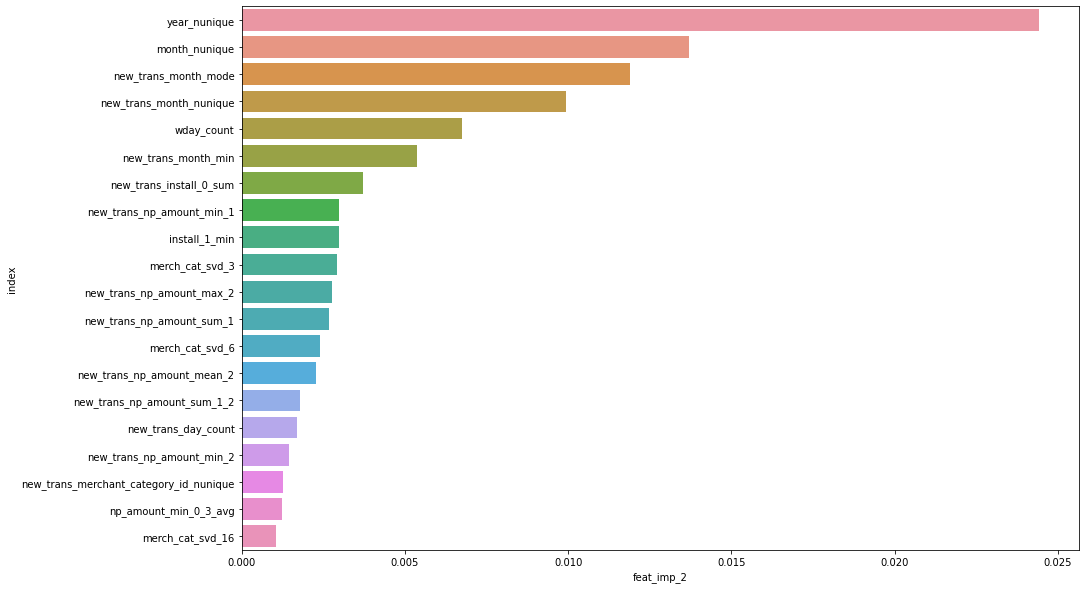

In [61]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot('feat_imp_2','index',data = sorted_feat_imp.iloc[:20],orient='h',ax=ax)